### Instrucciones para generar slides:

* Base:
  ```
  python3 -m nbconvert --to slides --TagRemovePreprocessor.remove_input_tags={\"to_remove\"} cheby_pasaaltos_slides.ipynb
  ```
* Con otro theme:
  * Clonar https://github.com/hakimel/reveal.js/ dentro de la carpeta donde se encuentra este archivo.
    Hacer checkout de `3.5.0`.
  * Correr
    ```
    python3 -m nbconvert --to slides --TagRemovePreprocessor.remove_input_tags={\"to_remove\"} cheby_pasaaltos_slides.ipynb --SlidesExporter.reveal_theme="serif" --reveal-prefix reveal.js
    ```
* Para ver las diapositivas sin generar el `htlm`, agragar `--post serve`.
* Para imprimir un `pdf` a partir de las diapositivas, agregar query `print-pdf` a la url, e.g. `http://127.0.0.1:8000/cheby_pasaaltos_slides.slides.html?print-pdf#/`. Funciona bien con chrome.
* Para imprimir `pdf` no en formato slide, usar:
  ```
  python3 -m nbconvert --to pdf --TagRemovePreprocessor.remove_cell_tags={\"to_remove_all\"} cheby_pasaaltos_slides
  ```

### Como editar slides:

* Para organizarlas, en un jupyter notebook ir a `View->Cell Toolbar->Slideshow`.
  Aparecera un desplegable en cada celda que permite lo mismo.
* Los comandos especificados arriba eliminan las celdas marcadas como `to_remove`, pero no se output.
  Ideal para gráficos, donde el código de generación es muy largo y queda feo el slide.
  Para esto, ir a `View->Cell Toolbar->Tags`, y agregar el tag mensionado anteriormente a las celdas que se deseé.
  Para generar `pdf` use un tag distinto: `to_remove_all`.
  Esto se debe a que `remove_input_tags` preprocessor tiene un bug y elimina el output también en ese caso.

# Ejemplo filtro Chebyshev pasaaltos

## Plantilla

|  $\alpha$               |  $f$  |
|-------------------------|-------|
|  $\alpha_{max}$ = 1dB   | 45Hz  |
|  $\alpha_{min}$ = 20dB  | 10Hz  |


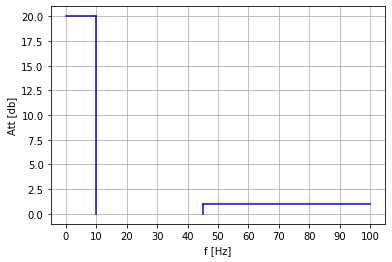

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

w_banda_paso = np.linspace(45, 100)
w_banda_att = np.linspace(0, 10)
att_min = 20  # dB
att_max = 1  # dB

# Lineas verticales para mejor visualizacion
vertical_banda_paso = np.linspace(0, att_max)
vertical_banda_att = np.linspace(0, att_min)

# Ploteo
fig, ax = plt.subplots()
ax.ticklabel_format(useOffset=False)
ax.set_ylabel('Att [db]')
ax.set_xlabel('f [Hz]')
ax.grid(True)
ticks = range(0, 101,10)
ax.set_xticks(ticks)
ax.plot(w_banda_paso, [att_max] * len(w_banda_paso), '-b')
ax.plot(w_banda_att, [att_min] * len(w_banda_att), '-b')
ax.plot([45] * len(vertical_banda_paso), vertical_banda_paso, '-b')
ax.plot([10] * len(vertical_banda_att), vertical_banda_att, '-b')

plt.show()

## Plantilla normalizada

In [2]:
import math as m

w_p = 2 * m.pi * 45
w_s = 2 * m.pi * 10

w_p_n = 1
w_s_n = w_s / w_p

print(f'w_p_n = {w_p_n}, w_s_n = {w_s_n}')

w_p_n = 1, w_s_n = 0.2222222222222222


## Plantilla pasabajos prototipo

In [3]:
w_p_lp = 1 / w_p_n
w_s_lp = 1 / w_s_n

print(f'w_p_lp = {w_p_lp}, w_s_lp = {w_s_lp}')

w_p_lp = 1.0, w_s_lp = 4.5


## Orden del filtro



In [4]:
alpha_max = 1    # dB
alpha_min = 20   # dB

epsilon = m.sqrt(m.pow(10, 0.1 * alpha_max) - 1)
N = m.acosh((m.pow(10, alpha_min * 0.1) - 1) / (m.pow(10, alpha_max * 0.1) - 1)) / (2 * m.acosh(w_s_lp))
N = m.ceil(N)

print(f'epsilon: {epsilon}, N: {N}')

epsilon: 0.5088471399095875, N: 2


## Obtención transferencia pasabajos

Formula recurrencia:

$c_n(\omega) = 2 * \omega * c_{n-1}(\omega) - c_{n-2}(\omega)$

| n   | $c_n$($\omega$) |
|:---:|:---:|
| 0 | 1 |
| 1 | $\omega$ |
| 2 | 2*$\omega^2$-1|

$\epsilon \simeq 0.51$

Módulo:

$H(j\omega)*H(-j\omega) = \frac{1}{1 + \epsilon^2 * c^2_2(w)} = \frac{1}{4* \epsilon^2 * \omega^4 - 4 * \epsilon^2 * \omega^2 + 1 + \epsilon^2}$

Factorizamos para obtener $H(s)$:

$H(s)*H(-s) = \frac{1}{1.04 * s^4 + 1.04 * s^2 + 1.26} = \frac{1}{a* s^2 + b * s + c}\frac{1}{a* s^2 - b * s + c}$

$c^2 = 1.26$

$a^2 = 1.04$

$2*a*c - b^2 = 1.04$

Resolviendo:

$a = 1.02$

$c = 1.12$

$b = \sqrt{2 * 1.02 * 1.12 - 1.04} = 1.12$

$H(s) = \frac{1}{a* s^2 + b * s + c} = \frac{1}{1.02* s^2 + 1.12 * s + 1.12}$


## Verificación prototipo pasabajos

[]

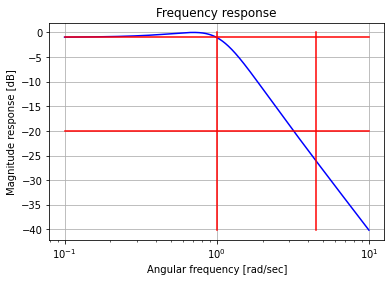

In [5]:
from scipy import signal

num = [1]
den = [1.02, 1.12, 1.12]
filtro = signal.TransferFunction(num, den)

w = np.logspace(np.log10(0.1), np.log10(10), num=1000)
w, mag, _ = filtro.bode(w=w)
vertical = np.linspace(min(mag), max(mag))

plt.figure()
plt.semilogx(w, mag, '-b')    # Bode magnitude plot
plt.grid(True)
plt.xlabel('Angular frequency [rad/sec]')
plt.ylabel('Magnitude response [dB]')
plt.title('Frequency response')

plt.semilogx(w, [-alpha_max] * len(w), '-r')
plt.semilogx(w, [-alpha_min] * len(w), '-r')
plt.semilogx([1] * len(vertical), vertical, '-r')
plt.semilogx([4.5] * len(vertical), vertical, '-r')

plt.plot()

0 zeros: []
2 poles: [-0.54901961+0.89253386j -0.54901961-0.89253386j]
gain: 0.9803921568627451


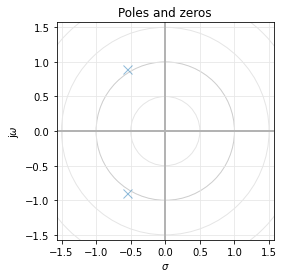

In [6]:
import splane

splane.pzmap(filtro)

## Obtención transferencia pasaaltos normalizada

Kernel transformación:

$K(s) = \frac{1}{s}$

Obtengo $H(s)$ del pasaaltos:

$H(s) = \frac{1}{1.02 * s^2 + 1.12 * s + 1.12} |_{s -> 1/s}$

$H(s) = \frac{1}{1.02 * (1/s)^2 + 1.12 * (1/s) + 1.12}$

$H(s) = \frac{s^2}{1.12 * s^2 + 1.12 * s + 1.02}$

## Verificacion filtro pasaaltos normalizado

[]

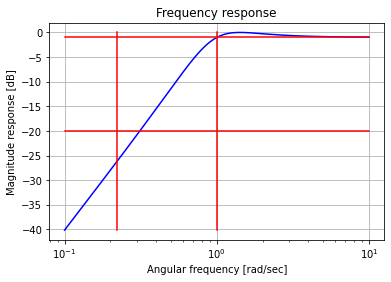

In [7]:
from scipy import signal

num = [1, 0, 0]
den = [1.12, 1.12, 1.02]
filtro = signal.TransferFunction(num, den)

w = np.logspace(np.log10(0.1), np.log10(10), num=1000)
w, mag, _ = filtro.bode(w=w)
vertical = np.linspace(min(mag), max(mag))

plt.figure()
plt.semilogx(w, mag, '-b')    # Bode magnitude plot
plt.grid(True)
plt.xlabel('Angular frequency [rad/sec]')
plt.ylabel('Magnitude response [dB]')
plt.title('Frequency response')

plt.semilogx(w, [-alpha_max] * len(w), '-r')
plt.semilogx(w, [-alpha_min] * len(w), '-r')
plt.semilogx([1] * len(vertical), vertical, '-r')
plt.semilogx([1/4.5] * len(vertical), vertical, '-r')

plt.plot()

2 zeros: [0. 0.]
2 poles: [-0.5+0.81284333j -0.5-0.81284333j]
gain: 0.8928571428571428


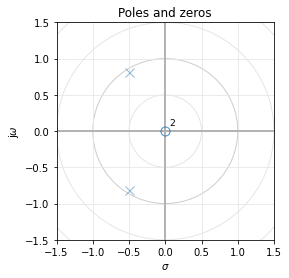

In [8]:
import splane

splane.pzmap(filtro)